In [1]:
!pip install mlflow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Convert to DataFrame for easier handling
X = pd.DataFrame(X, columns=iris.feature_names)
y = pd.Series(y)

# 1. Data Preprocessing

# Check for missing values
print("Checking for missing values in the dataset:")
print(X.isnull().sum())

# If missing values exist, we'll use SimpleImputer to replace them
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# 2. Categorical Handling
# For this dataset, there are no categorical variables, but we will add a fake categorical feature for demonstration
X_scaled['category'] = np.random.choice(['A', 'B', 'C'], size=len(X_scaled))



Checking for missing values in the dataset:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


In [3]:
# Encode categorical variables (if any)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Identify categorical columns
categorical_cols = X_scaled.select_dtypes(include=['object']).columns

# Apply one-hot encoding for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_scaled.columns.difference(categorical_cols)),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# 3. Complex Model with Hyperparameter Tuning
# We'll use RandomForest as a base model and perform hyperparameter tuning using GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

# Set up a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Get the best model and print the parameters
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



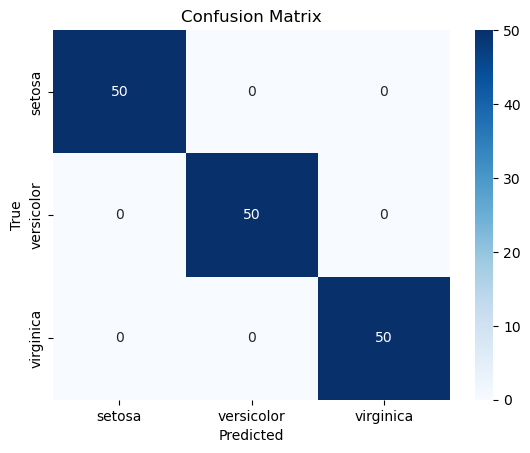

In [4]:
# 4. Model Evaluation
# Make predictions
y_pred = best_model.predict(X_scaled)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:")
print(classification_report(y, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


2025/03/10 12:41:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run logged with ID: 713c86e3999345cc82eda7b3687f9764


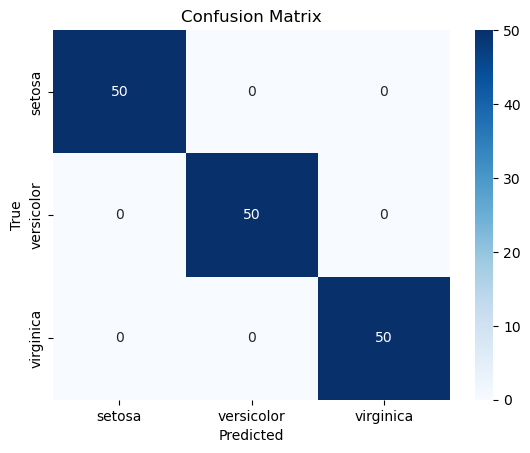

In [5]:

# 5. MLflow Logging
with mlflow.start_run():
    # Log parameters (model and data preprocessing)
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", grid_search.best_params_['classifier__n_estimators'])
    mlflow.log_param("max_depth", grid_search.best_params_['classifier__max_depth'])
    mlflow.log_param("min_samples_split", grid_search.best_params_['classifier__min_samples_split'])
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)

    # Log the model
    mlflow.sklearn.log_model(best_model, "random_forest_model")
    
    # Log confusion matrix as an artifact (you can save as a file)
    confusion_matrix_file = "confusion_matrix.png"
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_file)
    mlflow.log_artifact(confusion_matrix_file)

    # Save run details in JSON format
    run_id = mlflow.active_run().info.run_id
    run_data = {
        "run_id": run_id,
        "parameters": grid_search.best_params_,
        "metrics": {
            "accuracy": accuracy
        }
    }

    with open(f"mlflow_run_{run_id}.json", "w") as f:
        json.dump(run_data, f, indent=4)

print(f"Run logged with ID: {run_id}")
